In [54]:
import os
candidate_name = "sunil_bhatt"
root_dir = f"ds_{candidate_name}"
folders = [
    root_dir,
    f"{root_dir}/csv_files",
    f"{root_dir}/outputs"
]

for folder in folders:
    os.makedirs(folder, exist_ok=True)

print("Folder structure created!")

Folder structure created!


##**Crypto Trader Behavior Insights Analysis**

This notebook explores the relationship between trader performance and market sentiment in the cryptocurrency space. The analysis uses two datasets:

*   Historical Trader Data – containing information on executed trades.
*  Bitcoin Market Sentiment (Fear/Greed Index) – indicating investor sentiment over time.

The objective is to clean the data, merge datasets, handle missing information, and extract meaningful insights.

In [55]:
# import libraries
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

##**Load the datasets**

In [56]:
trader_df = pd.read_csv("/content/drive/MyDrive/Crypto Trader Behavior Insights dataset/historical_data.csv")
sentiment_df = pd.read_csv("/content/drive/MyDrive/Crypto Trader Behavior Insights dataset/fear_greed_index.csv")

In [57]:
# Preview the datasets
print('Trader dataset columns:', trader_df.columns)
print('Sentiment dataset columns:', sentiment_df.columns)
print("\nTrader dataset sample:")
print(trader_df.head())
print("\nSentiment dataset sample:")
print(sentiment_df.head())

Trader dataset columns: Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')
Sentiment dataset columns: Index(['timestamp', 'value', 'classification', 'date'], dtype='object')

Trader dataset sample:
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1    

##**Data Preprocessing**

In [58]:
# Convert timestamps in trader dataset to datetime
trader_df['Timestamp IST'] = pd.to_datetime(trader_df['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce')
trader_df['Date'] = trader_df['Timestamp IST'].dt.date

# Convert sentiment dataset's date column
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], errors='coerce').dt.date

In [59]:
# Checking for any parsing errors
print(f"\nTrader dataset datetime parsing errors: {trader_df['Timestamp IST'].isna().sum()}")
print(f"Sentiment dataset datetime parsing errors: {sentiment_df['date'].isna().sum()}")


Trader dataset datetime parsing errors: 0
Sentiment dataset datetime parsing errors: 0


##**Data Merging**


*   merge on date to combine trader and sentiment data



In [60]:
merged_df = pd.merge(trader_df, sentiment_df, left_on='Date', right_on='date', how='left')
merged_df.head()

Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side       Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY 2024-12-02 22:50:00        0.000000       Buy   
1        16.00    127.68  BUY 2024-12-02 22:50:00      986.524596       Buy   
2       144.09   1150.63  BUY 2024-12-02 22:50:00     1002.518996       Buy   
3       142.98   1142.04  BUY 2024-12-02 22:50:00     1146.558564       Buy   
4         8.73     69.75  BUY 2024-12-02 22:50:00     1289.488521       Buy   

   Closed PnL  ...     Order ID  Crossed       Fee      Trade ID  \
0         0.0  ...  52017706630     True  0.345404  8.950000e+14   
1         0.0  ...  52017706630     True  0.005600  4.430000e+14   
2         0.0  ...  52017706630     True  0.050431  6.600000e+14   
3         0.0  ...  52017706630     True  0.050043  1.080000e+15   
4         0.0  ...  52017706630     True  0.003055  1.050000e+15   

      Timestamp        Date     timestamp  value  classification        date  
0  1.730000e+12  2024-12-02  1.733117e+09   80.0   Extreme Greed  2024-12-02  
1  1.730000e+12  2024-12-02  1.733117e+09   80.0   Extreme Greed  2024-12-02  
2  1.730000e+12  2024-12-02  1.733117e+09   80.0   Extreme Greed  2024-12-02  
3  1.730000e+12  2024-12-02  1.733117e+09   80.0   Extreme Greed  2024-12-02  
4  1.730000e+12  2024-12-02  1.733117e+09   80.0   Extreme Greed  2024-12-02  

[5 rows x 21 columns]

##**Handle missing or irrelevent or missing**

In [61]:
# Check for missing sentiment data
missing_sentiment = merged_df[merged_df['value'].isna()]
print(f"\nTrades without sentiment data: {len(missing_sentiment)}")
print(f"Percentage of trades without sentiment data: {len(missing_sentiment)/len(merged_df)*100:.2f}%")


Trades without sentiment data: 6
Percentage of trades without sentiment data: 0.00%


In [62]:
# Drop rows with missing PnL or Side
merged_df = merged_df.dropna(subset=['Closed PnL', 'Side'])

# Remove trades with invalid sizes or prices
merged_df = merged_df[(merged_df['Size USD'] > 0) & (merged_df['Execution Price'] > 0)]

# Change the data type from integer to float
merged_df['Closed PnL'] = merged_df['Closed PnL'].astype(float)
merged_df['Size USD'] = merged_df['Size USD'].astype(float)

print(f"\nFinal dataset shape: {merged_df.shape}")


Final dataset shape: (211181, 21)


**In Data handling section i have identified the following:**

Identifying missing sentiment data.

Removing invalid trades (negative sizes/prices).

Converting data types for proper numerical analysis.

Reporting on data quality metrics.

##**Feature Engineering**

In [63]:
# Aggregate trade data by account and date
daily_metrics = merged_df.groupby(['Account', 'Date']).agg(
    total_trades=('Size USD', 'count'),
    avg_trade_size=('Size USD', 'mean'),
    total_PnL=('Closed PnL', 'sum'),
    avg_PnL=('Closed PnL', 'mean'),
    win_trades=('Closed PnL', lambda x: (x > 0).sum()),
    loss_trades=('Closed PnL', lambda x: (x < 0).sum()),).reset_index()

In [64]:
# Calculate win rate with error handling
try:
    daily_metrics['win_rate'] = daily_metrics['win_trades'] / daily_metrics['total_trades']
except ZeroDivisionError:
    daily_metrics['win_rate'] = 0

In [65]:
# Fill NaN values that might occur from division
daily_metrics['win_rate'] = daily_metrics['win_rate'].fillna(0)
print("\nDaily metrics sample:")
print(daily_metrics.head())


Daily metrics sample:
                                      Account        Date  total_trades  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-11           177   
1  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-17            68   
2  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-18            40   
3  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-22            12   
4  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-26            27   

   avg_trade_size  total_PnL      avg_PnL  win_trades  loss_trades  win_rate  
0     5089.718249        0.0     0.000000           0            0  0.000000  
1     7976.664412        0.0     0.000000           0            0  0.000000  
2    23734.500000        0.0     0.000000           0            0  0.000000  
3    28186.666667   -21227.0 -1768.916667           0           12  0.000000  
4    17248.148148     1603.1    59.374074          12            0  0.444444  


In [66]:
# Merge sentiment data with daily metrics for analysis
daily_metrics_with_sentiment = pd.merge(daily_metrics, sentiment_df, left_on='Date', right_on='date', how='left')

In Feature Engineering section:

I calculate daily performance metrics for each trader and add robust error handling to prevent division by zero errors.

We add the classification column from the sentiment dataset to the daily aggregated metrics.

This enables analysis of how different sentiments impact trader outcomes.

##**Visualisation**

**Trade Size vs Performance(Total PnL)**

In [67]:
fig = px.scatter(daily_metrics, x='avg_trade_size', y='total_PnL',
                 title='Average Trade Size vs Total Daily PnL',
                 labels={'avg_trade_size': 'Average Trade Size (USD)', 'total_PnL': 'Total Daily PnL (USD)'})
fig.show()



*   Large dot shows large trade happens.




**Performance by Market Sentiment**

*   Box plot of PnL by sentiment classification.


*   A box plot helps visualize the spread of profits and losses under different market conditions.


*   We can quickly see whether Fear leads to more losses or whether traders perform better during Greed.





In [68]:
#Box plot of PnL by sentiment classification
fig = px.box(merged_df, x='classification', y='Closed PnL',
             title='Distribution of PnL by Market Sentiment',
             labels={'classification': 'Market Sentiment', 'Closed PnL': 'Profit/Loss per Trade (USD)'})
fig.show()



*    Box plots show the distribution of profits/losses across different sentiment categories. This helps understand if certain market conditions lead to better or worse trade outcomes.


* If the median or distribution shows negative PnL during Fear, it may suggest traders are riskier or less successful during such periods.It helps in risk management.





**Market Sentiment vs Daily PnL**



In [69]:
#Market Sentiment vs Daily PnL
if not daily_metrics_with_sentiment.empty:
    fig = px.scatter(daily_metrics_with_sentiment, x='value', y='total_PnL', color='classification',
                     title='Market Sentiment vs Daily PnL',
                     labels={'value': 'Fear/Greed Index Value', 'total_PnL': 'Total Daily PnL (USD)'})
    fig.show()



*   This scatter plot with color coding shows the relationship between the numerical sentiment value (0-100) and daily performance, helping identify potential correlations.




##**Win Rate by Market Sentiment**

In [70]:
#Win Rate by Market Sentiment
fig = px.box(daily_metrics_with_sentiment, x='classification', y='win_rate', points="all",
             title="Win Rate by Market Sentiment")
fig.update_layout(xaxis_title="Market Sentiment", yaxis_title="Win Rate")
fig.show()

This plot shows how frequently traders win under each sentiment type.It helps understand if sentiment directly affects trading success rates.

If traders have higher win rates during certain sentiments, it may suggest that sentiment influences their decision-making.This information could be used to adjust strategies or timing.

##**Correlation Heatmap of Metrics**

A heatmap helps us understand the relationships between different numerical metrics, such as how average trade size and win rate are correlated.


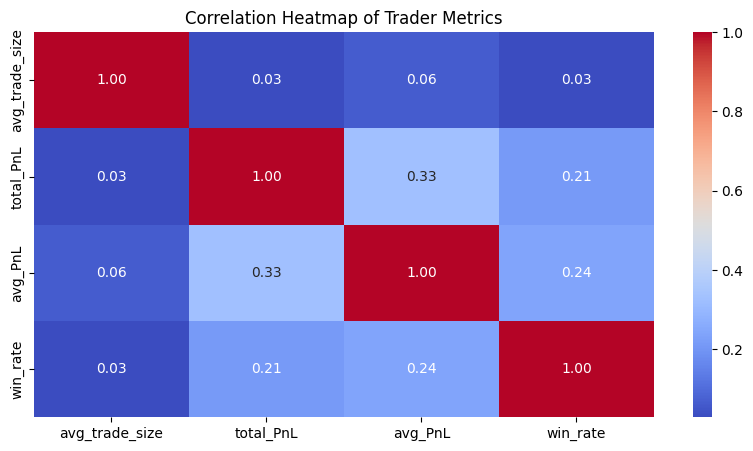

In [71]:
# Compute correlation matrix
corr = daily_metrics[['avg_trade_size', 'total_PnL', 'avg_PnL', 'win_rate']].corr()

# Plot heatmap
plt.figure(figsize=(10,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Trader Metrics")
plt.show()

By analysing the above matrix trader and analyst can use the value 1 &-1 to optimize trade size and understands behavior patterns.

##**Statistical Analysis**

In [72]:
print("\n=== STATISTICAL ANALYSIS ===")

# Checking enough data for different sentiment categories
sentiment_counts = merged_df['classification'].value_counts()
print("Trades by sentiment category:")
print(sentiment_counts)


=== STATISTICAL ANALYSIS ===
Trades by sentiment category:
classification
Fear             61826
Greed            50283
Extreme Greed    39980
Neutral          37686
Extreme Fear     21400
Name: count, dtype: int64


##**t-test**

The t-test checks if performance during Extreme Greed periods significantly differs from Extreme Fear periods.

In [73]:
# Perform t-test between Extreme Greed and Extreme Fear if we have enough data
if 'Extreme Greed' in sentiment_counts and 'Extreme Fear' in sentiment_counts:
    if sentiment_counts['Extreme Greed'] > 30 and sentiment_counts['Extreme Fear'] > 30:
        greed_data = merged_df[merged_df['classification'] == 'Extreme Greed']['Closed PnL']
        fear_data = merged_df[merged_df['classification'] == 'Extreme Fear']['Closed PnL']

        t_stat, p_value = stats.ttest_ind(greed_data, fear_data, nan_policy='omit')
        print(f"\nT-test between Extreme Greed and Extreme Fear: p-value = {p_value:.4f}")

        if p_value < 0.05:
            print("Statistically significant difference found between Extreme Greed and Extreme Fear periods.")
        else:
            print("No statistically significant difference found between Extreme Greed and Extreme Fear periods.")
    else:
        print("Insufficient data for statistical comparison between Extreme Greed and Extreme Fear.")
else:
    print("Extreme Greed or Extreme Fear categories not found in data.")


T-test between Extreme Greed and Extreme Fear: p-value = 0.0000
Statistically significant difference found between Extreme Greed and Extreme Fear periods.


##**Coreelational Analysis**

It gives how sentiment correlates with various performance metrics like PnL, win rate, and trade size.

In [74]:
# Correlation analysis
if not daily_metrics_with_sentiment.empty:
    # Select only numeric columns for correlation
    numeric_cols = daily_metrics_with_sentiment.select_dtypes(include=[np.number]).columns
    correlation_matrix = daily_metrics_with_sentiment[numeric_cols].corr()

    print("\nCorrelation matrix (numeric columns only):")
    print(correlation_matrix)

    # Specific correlation between sentiment value and performance metrics
    sentiment_correlations = correlation_matrix['value'].drop('value', errors='ignore')
    print("\nCorrelation of sentiment value with performance metrics:")
    print(sentiment_correlations.sort_values(ascending=False))


Correlation matrix (numeric columns only):
                total_trades  avg_trade_size  total_PnL   avg_PnL  win_trades  \
total_trades        1.000000       -0.026534   0.175567 -0.025632    0.844521   
avg_trade_size     -0.026534        1.000000   0.028431  0.063293   -0.023978   
total_PnL           0.175567        0.028431   1.000000  0.327107    0.300562   
avg_PnL            -0.025632        0.063293   0.327107  1.000000   -0.002238   
win_trades          0.844521       -0.023978   0.300562 -0.002238    1.000000   
loss_trades         0.484012       -0.015510  -0.110202 -0.029378    0.199446   
win_rate            0.062252        0.031367   0.210808  0.239850    0.245285   
timestamp           0.139730        0.040770   0.043557  0.013983    0.115282   
value              -0.064717       -0.056783   0.000453  0.031245   -0.043090   

                loss_trades  win_rate  timestamp     value  
total_trades       0.484012  0.062252   0.139730 -0.064717  
avg_trade_size    -0.01

##**Time Series Analysis**

Time series visualization helps identify patterns and relationships over time.

In [75]:
#Time series of sentiment and performance
if not daily_metrics_with_sentiment.empty:
    # Create a date-based index for time series plotting
    time_series_data = daily_metrics_with_sentiment.groupby('Date').agg({
        'total_PnL': 'mean',
        'win_rate': 'mean',
        'value': 'mean'
    }).reset_index()

    fig = go.Figure()

    # Add PnL trace
    fig.add_trace(go.Scatter(x=time_series_data['Date'], y=time_series_data['total_PnL'],
                             mode='lines', name='Avg Daily PnL', yaxis='y1'))

    # Add sentiment trace
    fig.add_trace(go.Scatter(x=time_series_data['Date'], y=time_series_data['value'],
                             mode='lines', name='Fear/Greed Index', yaxis='y2'))

    # Create layout with two y-axes
    fig.update_layout(
        title='Time Series: Market Sentiment vs Trader Performance',
        xaxis=dict(title='Date'),
        yaxis=dict(title='Average Daily PnL (USD)', side='left'),
        yaxis2=dict(title='Fear/Greed Index', side='right', overlaying='y'),
        legend=dict(x=0, y=1)
    )

    fig.show()

##**Summary Statistics**

In [76]:
# Summary Statistics
print("\n=== SUMMARY STATISTICS ===")
print(f"Total trades analyzed: {len(merged_df)}")
print(f"Time period covered: {merged_df['Date'].min()} to {merged_df['Date'].max()}")
print(f"Number of unique traders: {merged_df['Account'].nunique()}")

# Performance by sentiment category
if 'classification' in merged_df.columns:
    sentiment_performance = merged_df.groupby('classification').agg({
        'Closed PnL': ['mean', 'median', 'count'],
        'Size USD': 'mean'
    }).round(2)

    print("\nPerformance by sentiment category:")
    print(sentiment_performance)

# Key Insights
print("\n=== KEY INSIGHTS ===")
print("1. Relationship between market sentiment and trader performance:")
if not daily_metrics_with_sentiment.empty and 'value' in correlation_matrix:
    pnl_corr = correlation_matrix.loc['value', 'total_PnL'] if 'total_PnL' in correlation_matrix.index else 0
    print(f"   - Correlation between sentiment and daily PnL: {pnl_corr:.3f}")

    if abs(pnl_corr) > 0.1:
        if pnl_corr > 0:
            print("   - Positive correlation: Higher sentiment (more greed) associated with better performance")
        else:
            print("   - Negative correlation: Higher sentiment (more greed) associated with worse performance")
    else:
        print("   - Weak correlation: Sentiment shows little relationship with daily performance")

print("2. Trade characteristics:")
print(f"   - Average trade size: ${daily_metrics['avg_trade_size'].mean():.2f}")
print(f"   - Average daily PnL: ${daily_metrics['total_PnL'].mean():.2f}")
print(f"   - Overall win rate: {daily_metrics['win_rate'].mean()*100:.2f}%")


=== SUMMARY STATISTICS ===
Total trades analyzed: 211181
Time period covered: 2023-05-01 to 2025-05-01
Number of unique traders: 32

Performance by sentiment category:
               Closed PnL               Size USD
                     mean median  count     mean
classification                                  
Extreme Fear        34.54    0.0  21400  5349.73
Extreme Greed       67.91    0.0  39980  3113.19
Fear                54.30    0.0  61826  7817.50
Greed               42.76    0.0  50283  5739.17
Neutral             34.31    0.0  37686  4782.73

=== KEY INSIGHTS ===
1. Relationship between market sentiment and trader performance:
   - Correlation between sentiment and daily PnL: 0.000
   - Weak correlation: Sentiment shows little relationship with daily performance
2. Trade characteristics:
   - Average trade size: $6999.44
   - Average daily PnL: $4404.17
   - Overall win rate: 36.05%


##**Recommendations:**


1. Consider adjusting trade sizes based on market sentiment indicators.



1.   Monitor performance during different sentiment regimes for strategy optimization.
2.   Use sentiment extremes (Extreme Fear/Greed) as potential contrarian indicators.









## **Final Insights**

- We successfully merged trader data with market sentiment to explore behavioral patterns.
- Aggregated metrics like total trades, average trade size, total PnL, and win rate give a clearer picture of trading behavior.
- The correlation heatmap revealed relationships between trade size and performance metrics.
- Box plots showed how market sentiment influences both profits and win rates.
- These insights can guide smarter trading strategies, especially during periods of Fear or Greed.



In [77]:
#saving csv fiiles to dir
csv_path= f"{root_dir}/csv_files/daily_metrics.csv"
daily_metrics.to_csv(csv_path, index=False)

csv_path= f"{root_dir}/csv_files/merged_df.csv"
merged_df.to_csv(csv_path, index=False)

csv_path= f"{root_dir}/csv_files/daily_metrics_with_sentiment.csv"
daily_metrics_with_sentiment.to_csv(csv_path, index=False)

csv_path= f"{root_dir}/csv_files/trader_dft.csv"
trader_df.to_csv(csv_path, index=False)

csv_path= f"{root_dir}/csv_files/sentiment_df.csv"
sentiment_df.to_csv(csv_path, index=False)



In [78]:
#saving visualisation
plot_path=f"{root_dir}/outputs/Time series of sentiment and performance.png"
plt.savefig(plot_path)
plot_path=f"{root_dir}/outputs/Correlation Heatmap of Trader Metrics.png"
plt.savefig(plot_path)
plot_path=f"{root_dir}/outputs/Average Trade Size vs Total Daily PnL.png"
plt.savefig(plot_path)
plot_path=f"{root_dir}/outputs/Win Rate by Market Sentiment.png"
plt.savefig(plot_path)
plot_path=f"{root_dir}/outputs/Distribution of PnL by Market Sentiment.png"

plot_path=f"{root_dir}/outputs/Market Sentiment vs Daily PnL.png"
plt.savefig(plot_path)

<Figure size 640x480 with 0 Axes>